# Writing Classifiers into MongoDB

Basically writing to disk is inefficient and by writing to disk we have do queries we couldn't do before.
First I'll write some boilerplate code to generate a trained classifier

In [1]:
from dao import DataAccess, LabelGetter
from config import dbc

from pipelines.alcohol import AlcoholPipeline

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

Generate data and split

In [2]:
X = DataAccess.get_as_dataframe(explode=False)
ll = LabelGetter(X)

In [77]:
X, y = ll.get_first_person_label()
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=23)

Generate classifier and fit

In [78]:
clf = AlcoholPipeline(global_features=["text"]).pipeline(LogisticRegression())

In [79]:
clf.fit(X_train, y_train)

Pipeline(steps=[('exploder', ExplodingRecordJoiner(user=['created_at', 'favourites_count', 'followers_count', 'friends_count', 'statuses_count', 'verified'])), ('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text', Pipeline(steps=[('getter', ItemGetter(key='text')), ('tfidf', TfidfVectorizer(a...',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0))])

# Serialization

In [80]:
__author__ = 'JasonLiu'

from datetime import datetime
from pickle import dumps

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt

from config import dbc


class ClassificationReporting:
    metrics = [accuracy_score, f1_score, confusion_matrix, classification_report]

    def __init__(self, clf, X_train, X_test, y_train, y_test, n_classes):
        """

        :param clf:
        :param X_train:
        :param X_test:
        :param y_train:
        :param y_test:
        :param n_classes:
        :return:
        """
        self.clf = clf
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

        self.n_classes = n_classes

        self.report = {}

    def serialize_classifier(self):
        self.report["type"] = type(self.clf.named_steps["clf"]).__name__
        self.report["clf"] = dumps(self.clf)

    def set_name(self, name):
        """

        :param name:
        :return:
        """
        self.report["name"] = name
        return self

    def set_level(self, level):
        """

        :param level:
        :return:
        """
        self.report["level"] = level
        return self

    def set_notes(self, notes):
        """

        :param notes:
        :return:
        """
        self.report["notes"] = notes
        return self

    def set_params(self, attr_name, attr):
        """

        :param attr_name:
        :param attr:
        :return:
        """
        self.report[attr_name] = attr
        return self

    def set_datetime(self):
        """

        :return:
        """
        self.report["created_at"] = str(datetime.today())
        return self

    def compute_metrics(self, prefix, X, y):
        """

        :param prefix:
        :param X:
        :param y:
        :return:
        """
        y_predict = self.clf.predict(X)
        results = {}
        # simple metrics
        for metric in self.metrics:
            kwargs = {}
            if metric == f1_score:
                kwargs["average"] = "weighted"
            result = metric(y_true=y, y_pred=y_predict, **kwargs)
            results[metric.__name__] = result.tolist() if hasattr(result, "tolist") else result
        self.report[prefix] = results

    def compute_rocauc(self):
        """

        :return:
        """
        # Binarize the output
        y_test = label_binarize(self.y_test, classes=list(range(self.n_classes)))

        # Compute ROC curve and ROC area for each class
        y_score = self.clf.predict_proba(self.X_test)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(self.n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        self.report["roc_auc"] = dict(
            fpr={str(k):v.tolist() for k,v in fpr.items()}, 
            tpr={str(k):v.tolist() for k,v in tpr.items()},
            roc_auc={str(k):v.tolist() for k,v in roc_auc.items()}
        )

    def create_report(self, output=False, show_roc=False):
        """

        :param output:
        :param show_roc:
        :return:
        """
        self.compute_rocauc()
        self.compute_metrics("training_results", self.X_train, self.y_train)
        self.compute_metrics("testing_results", self.X_test, self.y_test)
        self.serialize_classifier()

        if output:
            self.print()

        if show_roc:
            self.show()

        return self.report

    def print(self):
        """

        :return:
        """
        print("Training Results")
        print("~~~~~~~~~~~~~~~~")
        for k, v in self.report["training_results"].items():
            print(k, v, "\n", sep="\n")
        print()
        print()
        print("Testing Results Results")
        print("~~~~~~~~~~~~~~~~~~~~~~~")
        for k, v in self.report["testing_results"].items():
            print(k, v, "\n", sep="\n")
        print()
        print()

    def show(self):
        """

        :return:
        """
        fpr = self.report["roc_auc"]["fpr"]
        tpr = self.report["roc_auc"]["tpr"]
        roc_auc = self.report["roc_auc"]["roc_auc"]

        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

        for i in range(self.n_classes):
            i = str(i)
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic for {}'.format(self.report.get("name", "Classifier")))
        plt.legend(loc="lower right")
        plt.show()

In [81]:
reporting = ClassificationReporting(clf, X_train, X_test, y_train, y_test, 4)

Training Results
~~~~~~~~~~~~~~~~
accuracy_score
0.744343891402715


f1_score
0.7134575424272982


confusion_matrix
[[51, 38, 4, 0], [0, 180, 0, 0], [1, 21, 89, 0], [0, 43, 6, 9]]


classification_report
             precision    recall  f1-score   support

          0       0.98      0.55      0.70        93
          1       0.64      1.00      0.78       180
          2       0.90      0.80      0.85       111
          3       1.00      0.16      0.27        58

avg / total       0.82      0.74      0.71       442





Testing Results Results
~~~~~~~~~~~~~~~~~~~~~~~
accuracy_score
0.4840182648401826


f1_score
0.436799501867995


confusion_matrix
[[21, 38, 6, 0], [2, 70, 9, 0], [2, 37, 15, 0], [1, 14, 4, 0]]


classification_report
             precision    recall  f1-score   support

          0       0.81      0.32      0.46        65
          1       0.44      0.86      0.58        81
          2       0.44      0.28      0.34        54
          3       0.00      0.00      0.0

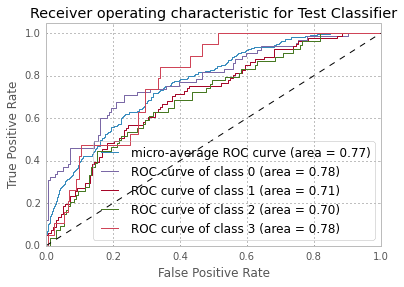

In [82]:
report = reporting\
 .set_name("Test Classifier")\
 .set_level("first_person")\
 .create_report(1,1)

# Writing

In [83]:
dbc.insert_one(report)